In [2]:
import gdown
# https://drive.google.com/file/d/10x-39P6o6QA9-BVnlnxDVib23rbMlHGL/view?usp=drive_link
file_id = "10x-39P6o6QA9-BVnlnxDVib23rbMlHGL"  # replace with actual file ID
output = "LCData.zip"

!gdown --id {file_id} -O {output}
!unzip -q {output} -d ./LCData

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10x-39P6o6QA9-BVnlnxDVib23rbMlHGL
From (redirected): https://drive.google.com/uc?id=10x-39P6o6QA9-BVnlnxDVib23rbMlHGL&confirm=t&uuid=90dc819b-f379-48ff-9fd6-150ff1e70f01
To: /content/LCData.zip
100% 2.43G/2.43G [00:32<00:00, 75.7MB/s]


In [76]:
# --- 1. Setup ---
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.optimizers import Adam


In [78]:
data_dir = "/content/LCData/Val/Urban"  # path to LoveDA validation set
image_dir = os.path.join(data_dir, "images_png")
mask_dir = os.path.join(data_dir, "masks_png")

X, y = [], []

In [79]:
# --- 2. Loop through images ---
n_samples_per_img = 200   # pixels per image to sample
max_images = 900           # optional limit to speed up

counter = 0
for fname in os.listdir(image_dir):
    if not fname.endswith(".png"):
        continue

    img = imread(os.path.join(image_dir, fname))       # (H,W,3)
    mask = imread(os.path.join(mask_dir, fname))       # (H,W), values 0–6 for classes

    h, w, _ = img.shape

    # sample random pixels
    xs = np.random.randint(0, h, n_samples_per_img)
    ys = np.random.randint(0, w, n_samples_per_img)

    for i in range(n_samples_per_img):
        r, g, b = img[xs[i], ys[i]]
        label = mask[xs[i], ys[i]]

        X.append([r, g, b])   # RGB pixel values
        y.append(label)       # class from mask

    counter += 1
    if counter >= max_images:
        break

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Number of unique classes:", np.unique(y,return_counts=True))

Feature matrix shape: (135400, 3)
Number of unique classes: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8), array([ 5237, 33984, 16244, 10035, 15351,  7165, 14036, 33348]))


In [82]:
X_bal, y_bal = [], []
num_classes = np.max(y)
for cls in range(num_classes):
    idx_cls = np.where(y == cls)[0]
    n = min(len(idx_cls), 5000)  # sample up to 5000 pixels per class
    sampled_idx = np.random.choice(idx_cls, n, replace=False)
    X_bal.append(X[sampled_idx])
    y_bal.append(y[sampled_idx])

X_bal = np.vstack(X_bal)
y_bal = np.hstack(y_bal)


In [83]:
y_bal.shape

(35000,)

In [84]:
# --- 4. Train/Val/Test split ---
X_train, X_temp, y_train, y_temp = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [85]:

# --- 5. Preprocess ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


In [86]:
# --- 6. ANN Model (16 hidden layers) ---
model = Sequential(name="DeepANN")

# Build hidden layers in a loop
for i in range(6):
    model.add(layers.Dense(
        units=64,
        activation="relu",
        name=f"Layer_{i}",
        input_shape=(3,) if i == 0 else ()  # only first layer needs input_shape
    ))
    model.add(layers.Dropout(0.3, name=f"Drop_{i}"))

# Final output layer
model.add(layers.Dense(
    units=num_classes,
    activation="softmax",
    name="Output"
))

# Compile with fixed learning rate
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DeepANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer_0 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_0 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_1 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_2 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_3 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_4 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_5 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,576 (84.28 KB)

 Trainable params: 21,576 (84.28 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:

# --- 7. Train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    verbose=1
)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2163 - loss: 1.8768 - val_accuracy: 0.4522 - val_loss: 1.4597
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3992 - loss: 1.4653 - val_accuracy: 0.4796 - val_loss: 1.2814
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4487 - loss: 1.3487 - val_accuracy: 0.5196 - val_loss: 1.2348
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4926 - loss: 1.3011 - val_accuracy: 0.5303 - val_loss: 1.2163
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5062 - loss: 1.2802 - val_accuracy: 0.5333 - val_loss: 1.2092
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5201 - loss: 1.2520 - val_accuracy: 0.5343 - val_loss: 1.2038
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5260 - loss: 1.2471 - val_accuracy: 0.5379 - val_loss: 1.1946
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5305 - loss: 1.2518 - val_accuracy: 0.5427 - val_lo

In [88]:

# --- 8. Evaluate ---
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5535 - loss: 1.1577
Test Accuracy: 0.557


Pixel-wise Accuracy: 0.5565714285714286

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       0.31      0.06      0.10       750
           2       0.61      0.15      0.25       750
           3       0.40      0.57      0.47       750
           4       0.47      0.73      0.57       750
           5       0.50      0.62      0.55       750
           6       0.58      0.76      0.66       750

    accuracy                           0.56      5250
   macro avg       0.55      0.56      0.51      5250
weighted avg       0.55      0.56      0.51      5250


Confusion Matrix:
 [[750   0   0   0   0   0   0]
 [  0  47  28 176 175 138 186]
 [  1  18 116 275 120 171  49]
 [  0  25  21 425 110 126  43]
 [  0  19   7  46 545  27 106]
 [  0  26  13 136  73 468  34]
 [  1  15   5   5 142  11 571]]


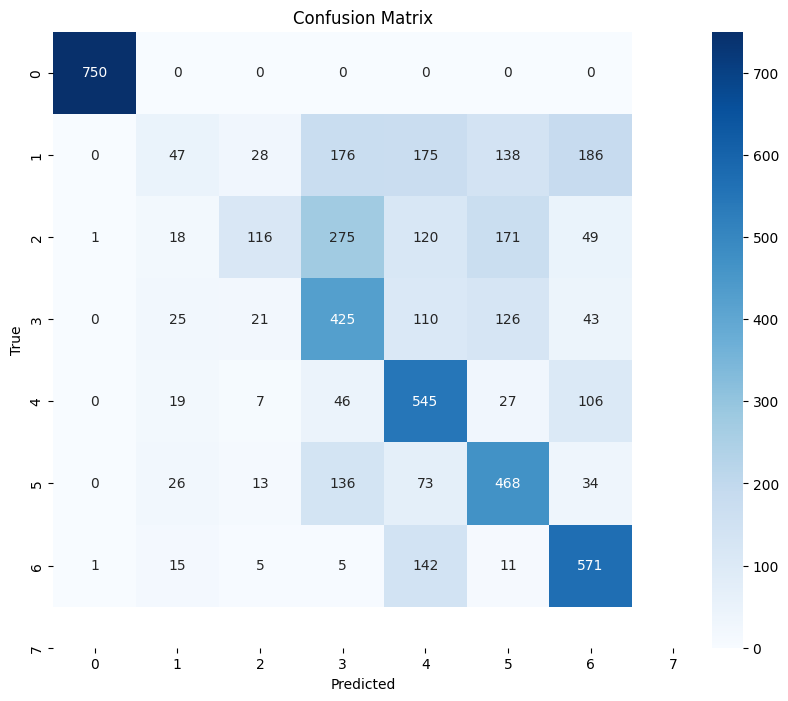

In [89]:
# --- Convert test labels back from one-hot ---
y_test_labels = np.argmax(y_test, axis=1)

# --- Predict class indices ---
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Metrics ---
print("Pixel-wise Accuracy:", accuracy_score(y_test_labels, y_pred))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred))

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


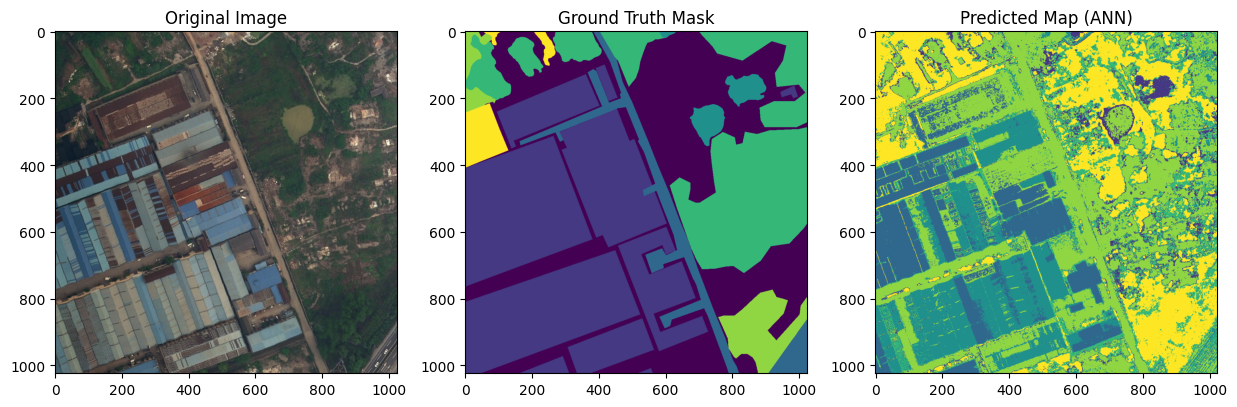

In [92]:
# --- 9. Predict and visualize on one full image ---
import matplotlib.pyplot as plt

# pick one image from val set
sample_file = os.listdir(image_dir)[0]   # take the first one
img = imread(os.path.join(image_dir, sample_file))
mask = imread(os.path.join(mask_dir, sample_file))

H, W, C = img.shape

# preprocess image pixels
img_scaled = scaler.transform(img.reshape(-1, C))

# predict per-pixel class
preds = model.predict(img_scaled, verbose=0)
pred_map = np.argmax(preds, axis=1).reshape(H, W)

# --- Plot ---
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask, )
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_map,)
plt.title("Predicted Map (ANN)")

plt.show()
